In [ ]:
! pip install tensorflow
! pip install -q kaggle
! pip install keras-preprocessing
! pip install tensorflow-text

In [7]:
import numpy as np
import pandas as pd
import re
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D, Dropout, BatchNormalization, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import Model
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
from keras.initializers import Constant
from keras.optimizers import Adam
import tensorflow_text as text

In [9]:
df = pd.read_csv("Twitter Sentiment Analysis/Dataset/data.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
data = df.copy()
df1 = df.copy()

In [11]:
df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

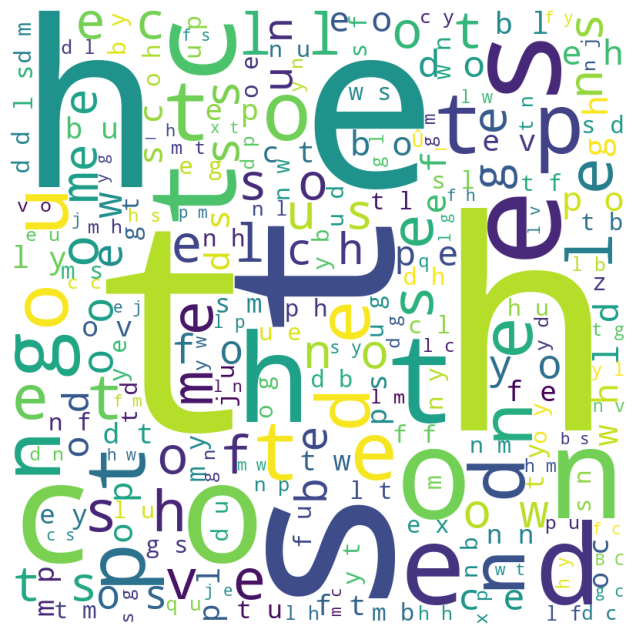

In [12]:
# visualizing the text through wordcloud
all_tweets = ' '.join(df['text'].map(lambda x: ' '.join(x)))
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_tweets)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Target Distribution')

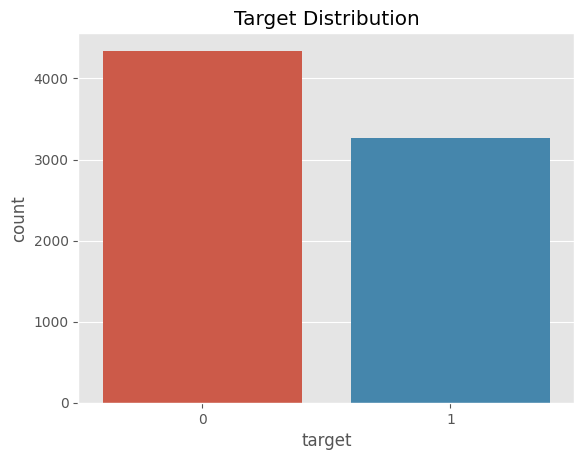

In [13]:
plt.style.use('ggplot')
sns.countplot(x='target',data=df)
plt.title('Target Distribution')

In [14]:
data = df.copy()

In [15]:
data['word count'] = data['text'].apply(lambda x : len(str(x).split()))

In [16]:
count_word = [\
            data[data["target"] == 1]["word count"],\
            data[data["target"] == 0]["word count"]]

Text(0.5, 0.98, 'Word Count')

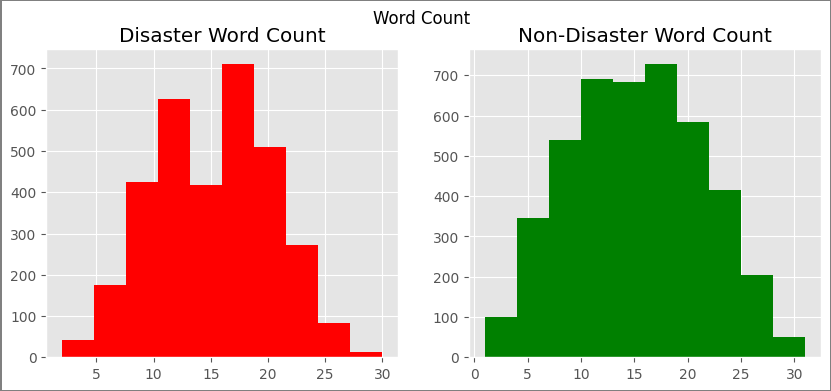

In [17]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), linewidth=2)
ax1.hist(count_word[0], color='red', linewidth=2)
ax1.set_title('Disaster Word Count')
ax2.hist(count_word[1], color='green', linewidth=2)
ax2.set_title('Non-Disaster Word Count')
fig.suptitle('Word Count')

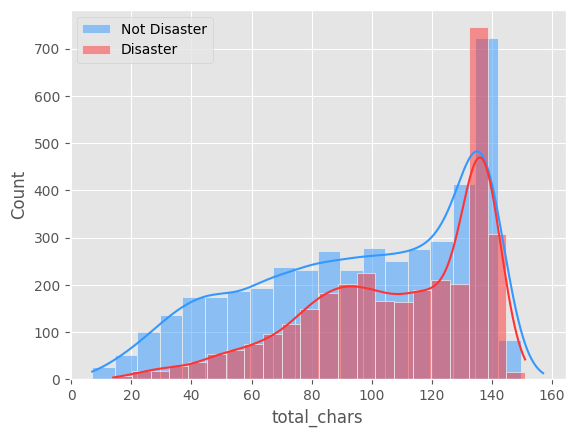

In [18]:
data['total_chars'] = data['text'].apply(lambda x: len(x))
sns.histplot(x=data[data['target'] == 0]['total_chars'], label='Not Disaster', kde=True,color='#3398FF')
sns.histplot(x=data[data['target'] == 1]['total_chars'], label='Disaster', kde=True,color='#FF3333')
plt.legend()
plt.show()

In [19]:
data

,id,keyword,location,text,target,word count,total_chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,137


## Data Cleaning

In [20]:
df = df.drop(['id', 'keyword', 'location'], axis=1)
df = df.drop_duplicates()

In [21]:
def clean_text(text):
  text = re.sub(r'#', '', text)
  text = re.sub(r'@[-)]+', '', text)
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'@[A-Za-z]+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?\/\/\S+', '', text)
  text = re.sub(r'&[a-z;]+', '', text)
  text = re.sub(r'[WATCH]', '', text)
  return text

In [22]:
df["text"] = df["text"].apply(clean_text)

In [23]:
df

,text,target
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask. anada,1
2,ll residents asked to 'shelter in place' are b...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,Just got sent this photo from Ruby laska as sm...,1
...,...,...
7604,orldNews Fallen powerlines on G:link tram: UPD...,1
7605,on the flip side I'm at almart and there is a ...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,wo giant cranes holding a bridge collapse into...,1


In [24]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [25]:
X.head()

,text
0,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. anada
2,ll residents asked to 'shelter in place' are b...
3,"13,000 people receive wildfires evacuation ord..."
4,Just got sent this photo from Ruby laska as sm...


In [26]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0, test_size=0.1)

## Data Preprocessing

In [28]:
max_vocab = 20000000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train.iloc[:, 0])

In [29]:
wordidx = tokenizer.word_index
V = len(wordidx)
print("Dataset vocab size =", V)

Dataset vocab size = 20051


In [30]:
train_seq = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
test_seq = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

In [31]:
print("Training Sequence", train_seq[0])
print("Testing Sequence", test_seq[0])

Training Sequence [63, 14, 68, 105, 408, 145, 50, 490, 11, 387, 22]
Testing Sequence [19162, 11085, 11086, 3554, 5393, 2378, 6102, 5, 586, 70, 12, 11087, 3, 1, 2]


In [32]:
train_pad = pad_sequences(train_seq)
test_pad = pad_sequences(test_seq, maxlen=train_pad.shape[1])
print("Length of training sequence:", train_pad.shape[1])
print("Length of testing sequence:", test_pad.shape[1])

Length of training sequence: 33
Length of testing sequence: 33


In [33]:
train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  63,  14,  68, 105,
       408, 145,  50, 490,  11, 387,  22], dtype=int32)

In [34]:
test_pad.shape

(753, 33)

In [35]:
y_test.shape

(753,)

##Model

#### Model-1 BERT



In [36]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [37]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model1 = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

In [38]:
model1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [39]:
h1 = model1.fit(X_train, y_train, epochs=20)

Epoch 1/20
212/212 [==============================] - 83s 327ms/step - loss: 0.6326 - accuracy: 0.6445
Epoch 2/20
212/212 [==============================] - 71s 335ms/step - loss: 0.5981 - accuracy: 0.6934
Epoch 3/20
212/212 [==============================] - 73s 343ms/step - loss: 0.5811 - accuracy: 0.7074
Epoch 4/20
212/212 [==============================] - 74s 349ms/step - loss: 0.5722 - accuracy: 0.7151
Epoch 5/20
212/212 [==============================] - 75s 351ms/step - loss: 0.5639 - accuracy: 0.7219
Epoch 6/20
212/212 [==============================] - 75s 352ms/step - loss: 0.5521 - accuracy: 0.7360
Epoch 7/20
212/212 [==============================] - 76s 357ms/step - loss: 0.5497 - accuracy: 0.7315
Epoch 8/20
212/212 [==============================] - 75s 354ms/step - loss: 0.5445 - accuracy: 0.7388
Epoch 9/20
212/212 [==============================] - 75s 356ms/step - loss: 0.5401 - accuracy: 0.7400
Epoch 10/20
212/212 [==============================] - 75s 354ms/step - l

In [40]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model1.evaluate(X_test, y_test)

24/24 [==============================] - 10s 345ms/step - loss: 0.5205 - accuracy: 0.7410


[0.5204774141311646, 0.7410358786582947]

In [41]:
y_pred = model1.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

24/24 [==============================] - 9s 355ms/step
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       416
           1       0.74      0.66      0.69       337

    accuracy                           0.74       753
   macro avg       0.74      0.73      0.73       753
weighted avg       0.74      0.74      0.74       753



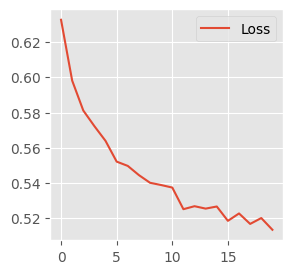

In [42]:
plt.figure(figsize=(3,3))
plt.plot(h1.history["loss"], label="Loss")
plt.legend()
plt.show()

In [43]:
accuracy_score(y_test, y_pred)

0.7410358565737052

#### Model-2 LSTM

In [44]:
T = train_pad.shape[1]
D = 20
M = 15

i = Input(shape=(T, ))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = Dense(1, activation="sigmoid")(x)
x = Dense(1, activation="sigmoid")(x)

model2 = Model(i, x)

In [45]:
model2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [46]:
h2 = model2.fit(train_pad, y_train, epochs=20)

Epoch 1/20
212/212 [==============================] - 25s 101ms/step - loss: 0.6758 - accuracy: 0.5761
Epoch 2/20
212/212 [==============================] - 6s 26ms/step - loss: 0.6505 - accuracy: 0.6189
Epoch 3/20
212/212 [==============================] - 5s 22ms/step - loss: 0.6287 - accuracy: 0.7009
Epoch 4/20
212/212 [==============================] - 4s 19ms/step - loss: 0.6105 - accuracy: 0.7284
Epoch 5/20
212/212 [==============================] - 2s 11ms/step - loss: 0.5921 - accuracy: 0.7466
Epoch 6/20
212/212 [==============================] - 2s 10ms/step - loss: 0.5774 - accuracy: 0.7559
Epoch 7/20
212/212 [==============================] - 2s 11ms/step - loss: 0.5636 - accuracy: 0.7605
Epoch 8/20
212/212 [==============================] - 3s 15ms/step - loss: 0.5516 - accuracy: 0.7639
Epoch 9/20
212/212 [==============================] - 4s 17ms/step - loss: 0.5416 - accuracy: 0.7659
Epoch 10/20
212/212 [==============================] - 2s 10ms/step - loss: 0.5311 - accu

In [47]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model2.evaluate(test_pad, y_test)

24/24 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.6490


[0.6428529620170593, 0.649040162563324]

In [48]:
y_pred = model2.predict(test_pad)
y_pred = np.squeeze(y_pred[:, -1])
y_pred = np.reshape(y_pred, (y_pred.shape[0], 1))
y_pred = np.where(y_pred > 0.5, 1, 0)
matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

24/24 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       416
           1       0.78      0.71      0.75       337

    accuracy                           0.78       753
   macro avg       0.78      0.78      0.78       753
weighted avg       0.78      0.78      0.78       753



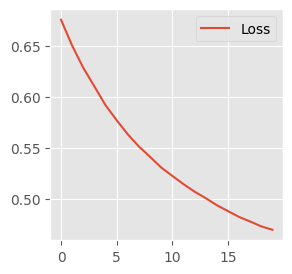

In [49]:
plt.figure(figsize=(3,3))
plt.plot(h2.history["loss"], label="Loss")
plt.legend()
plt.show()

In [50]:
accuracy_score(y_test, y_pred)

0.7822045152722443

The results show that LSTM gives much better accuracy as compared to BERT.
